In [1]:
import pandas as pd
import numpy as np
import random
import warnings
from utils import *
from datasets import *
from models import *

warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Set display options
pd.set_option("display.max_rows", 500)  # Replace 500 with your desired number of rows
pd.set_option(
    "display.max_columns", 10
)  # Replace 10 with your desired number of columns
pd.set_option("display.width", 1000)  # Adjust the width as needed
pd.set_option("display.max_colwidth", 50)  # Adjust the column width as needed

### Data Preparation

In [2]:
# Prepare the data
# Adjust your path here
quality_df_dir = './results/quality_scores_per_subject.csv'
features_dir = "dataset_sample/E4_aggregate/"
info_dir = "dataset_sample/participant_info.csv"
clean_df, new_features, good_quality_sids = data_preparation(
    threshold = 0.2,
    quality_df_dir, 
    features_dir, 
    info_dir)
print(clean_df.shape)
print(len(new_features))

/home/kw302/Projects/DREAMT/CHIL_Submission/datasets.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  path = str(features_dir) + str(info_df.SID[0]) + '_domain_features_df.csv'
/home/kw302/Projects/DREAMT/CHIL_Submission/datasets.py:125: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_subjects_fe_df = pd.concat([all_subjects_fe_df, sid_df], ignore_index=True)


(82671, 610)
597


### Split data to train, val, and test

In [3]:
SW_df, final_features = split_data(clean_df, good_quality_sids, new_features)
SW_df

,PPG_Rate_Mean,HRV_SDNN,HRV_MadNN,HRV_SDRMSSD,HRV_Prc20NN,...,Hypopnea,Multiple_Events,artifact,sid,BMI
1,87.451445,267.856258,277.987500,0.762788,468.750,...,0.0,0.0,0,S003,51.0
2,84.687304,280.299933,231.656250,0.672688,515.625,...,0.0,0.0,1,S003,51.0
3,90.889185,224.392912,208.490625,0.730625,465.625,...,0.0,0.0,1,S003,51.0
4,79.140186,303.274460,324.318750,0.769270,468.750,...,0.0,0.0,1,S003,51.0
5,90.383327,297.089740,289.570312,0.767894,450.000,...,0.0,0.0,1,S003,51.0
...,...,...,...,...,...,...,...,...,...,...,...
85066,61.392727,132.432765,23.165625,0.856175,1000.000,...,0.0,0.0,0,S102,26.0
85067,61.198295,138.500822,46.331250,1.081764,978.125,...,0.0,0.0,0,S102,26.0
85068,57.181574,18.233936,23.165625,0.781327,1031.250,...,0.0,0.0,0,S102,26.0
85069,57.535505,17.652470,23.165625,0.934502,1031.250,...,0.0,0.0,0,S102,26.0


In [4]:
import random
random.seed(0)
train_sids = random.sample(good_quality_sids, 56)
remaining_sids = [subj for subj in good_quality_sids if subj not in train_sids]
val_sids = random.sample(remaining_sids, 8)
test_sids = [subj for subj in remaining_sids if subj not in val_sids]

group_variables = ['AHI_Severity', 'Obesity']
# when idx == 0, it returns ['AHI_Severity'], the first variable in the list
# when idx == 1, it returns ['Obesity'], the second variable in the list
group_variable = get_variable(group_variables, idx = 0) # set your variable

In [5]:
X_train, y_train, group_train = train_test_split(SW_df, train_sids, final_features, group_variable)
print("Train data balance: ")
print(np.unique(y_train, return_counts=True))
print('')

X_val, y_val, group_val = train_test_split(SW_df, val_sids, final_features, group_variable)
print("Validation data balancpredicted_probabilitiese: ")
print(np.unique(y_val, return_counts=True))
print('')

X_test, y_test, group_test = train_test_split(SW_df, test_sids, final_features, group_variable)
print("Test data balance: ")
print(np.unique(y_test, return_counts=True))
print(y_train.sum())

Train data balance: 
(array([0., 1.]), array([33063, 24620]))

Validation data balancpredicted_probabilitiese: 
(array([0., 1.]), array([5001, 3038]))

Test data balance: 
(array([0., 1.]), array([10402,  6547]))
24620.0


### Resample data

In [6]:
X_train_resampled, y_train_resampled, group_train_resampled = resample_data(X_train, y_train, group_train, group_variable)

### LightGBM

In [7]:
final_lgb_model = LightGBM_engine(X_train_resampled, y_train_resampled, X_val, y_val)

100%|██████████| 50/50 [01:14<00:00,  1.49s/trial, best loss: -0.7025875190258752]
Best hyperparameters: {'learning_rate': 0.47589925010717243, 'max_depth': 5.0, 'n_estimators': 240.0, 'num_leaves': 20.0, 'reg_alpha': 32.0, 'reg_lambda': 3.1391479880607402}


/home/kw302/miniconda3/envs/dreamt/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33063, number of negative: 33063
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91238
[LightGBM] [Info] Number of data points in the train set: 66126, number of used features: 358
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[[31259  1804]
 [ 2474 22146]]


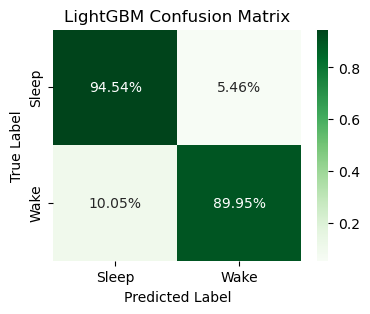

[[8757 1645]
 [ 953 5594]]


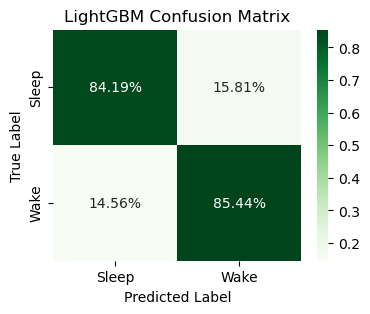

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,LightGBM,0.772759,0.854437,0.811548,0.841857,0.925547,0.903694,0.846717,0.675096


In [8]:
# calculate training scores
prob_ls_train, len_train, true_ls_train = compute_probabilities(
    train_sids, SW_df, final_features, "lgb", final_lgb_model, group_variable)
lgb_train_results_df = LightGBM_result(final_lgb_model, X_train, y_train, prob_ls_train, true_ls_train)

# # calculate testing scores
prob_ls_test, len_test, true_ls_test = compute_probabilities(
    test_sids, SW_df, final_features, "lgb", final_lgb_model, group_variable)
lgb_test_results_df = LightGBM_result(final_lgb_model, X_test, y_test, prob_ls_test, true_ls_test)
lgb_test_results_df


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


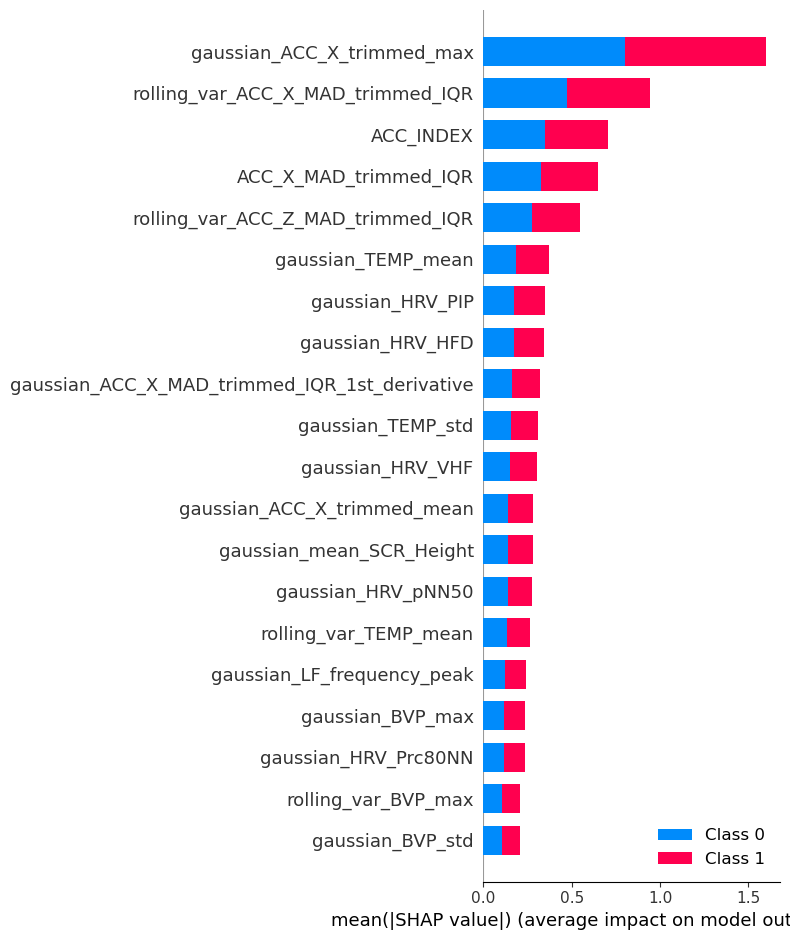

In [9]:
import shap
explainer = shap.TreeExplainer(final_lgb_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=final_features)

### LightGBM and LSTM post processing

In [10]:
dataloader_train = LSTM_dataloader(
    prob_ls_train, len_train, true_ls_train, batch_size=32
)

# Run LSTM model
LSTM_model = LSTM_engine(dataloader_train, num_epoch=300, hidden_layer_size=32, learning_rate=0.001) # set your num_epoch

Training on cuda:0


dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1


Epoch 5/300 - Loss: 0.6685, Accuracy: 0.5155
Epoch 10/300 - Loss: 0.6177, Accuracy: 0.5122
Epoch 15/300 - Loss: 0.5261, Accuracy: 0.7565
Epoch 20/300 - Loss: 0.3585, Accuracy: 0.8154
Epoch 25/300 - Loss: 0.3068, Accuracy: 0.8072
Epoch 30/300 - Loss: 0.2799, Accuracy: 0.8160
Epoch 35/300 - Loss: 0.2658, Accuracy: 0.8230
Epoch 40/300 - Loss: 0.2574, Accuracy: 0.8226
Epoch 45/300 - Loss: 0.2525, Accuracy: 0.8222
Epoch 50/300 - Loss: 0.2484, Accuracy: 0.8226
Epoch 55/300 - Loss: 0.2453, Accuracy: 0.9367
Epoch 60/300 - Loss: 0.2426, Accuracy: 0.9373
Epoch 65/300 - Loss: 0.2403, Accuracy: 0.9379
Epoch 70/300 - Loss: 0.2381, Accuracy: 0.9382
Epoch 75/300 - Loss: 0.2361, Accuracy: 0.9386
Epoch 80/300 - Loss: 0.2342, Accuracy: 0.9389
Epoch 85/300 - Loss: 0.2324, Accuracy: 0.9388
Epoch 90/300 - Loss: 0.2307, Accuracy: 0.9387
Epoch 95/300 - Loss: 0.2291, Accuracy: 0.9388
Epoch 100/300 - Loss: 0.2275, Accuracy: 0.9391
Epoch 105/300 - Loss: 0.2258, Accuracy: 0.9393
Epoch 110/300 - Loss: 0.2241, Acc

[[9042 1360]
 [ 875 5672]]


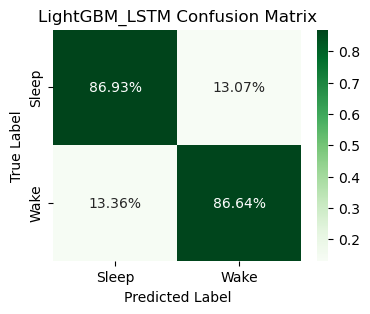

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,LightGBM_LSTM,0.806598,0.866351,0.835408,0.869256,0.936992,0.914593,0.868134,0.72064


In [11]:
dataloader_test = LSTM_dataloader(
    prob_ls_test, len_test, true_ls_test, batch_size=1
)
lgb_lstm_test_results_df = LSTM_eval(LSTM_model, dataloader_test, true_ls_test, 'LightGBM_LSTM')
lgb_lstm_test_results_df

### GPBoosting

In [12]:
final_gpb_model = GPBoost_engine(X_train_resampled, group_train_resampled, y_train_resampled, X_val, y_val, group_val)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

Found `num_boost_round` in params. Will use it instead of argument



  2%|▏         | 1/50 [00:04<03:28,  4.26s/trial, best loss: -0.7048486820696388]

Found `num_boost_round` in params. Will use it instead of argument



  4%|▍         | 2/50 [00:07<03:09,  3.94s/trial, best loss: -0.7056833558863328]

Found `num_boost_round` in params. Will use it instead of argument



  6%|▌         | 3/50 [00:14<04:10,  5.34s/trial, best loss: -0.7096343296042744]

Found `num_boost_round` in params. Will use it instead of argument



  8%|▊         | 4/50 [00:19<03:43,  4.87s/trial, best loss: -0.7113800638762818]

Found `num_boost_round` in params. Will use it instead of argument



 10%|█         | 5/50 [00:23<03:27,  4.62s/trial, best loss: -0.7113800638762818]

Found `num_boost_round` in params. Will use it instead of argument



 12%|█▏        | 6/50 [00:30<03:56,  5.37s/trial, best loss: -0.7194960212201591]

Found `num_boost_round` in params. Will use it instead of argument



 14%|█▍        | 7/50 [00:32<03:04,  4.30s/trial, best loss: -0.7194960212201591]

Found `num_boost_round` in params. Will use it instead of argument



 16%|█▌        | 8/50 [00:34<02:30,  3.58s/trial, best loss: -0.7194960212201591]

Found `num_boost_round` in params. Will use it instead of argument



 18%|█▊        | 9/50 [00:38<02:36,  3.82s/trial, best loss: -0.7194960212201591]

Found `num_boost_round` in params. Will use it instead of argument



 20%|██        | 10/50 [00:41<02:18,  3.46s/trial, best loss: -0.7194960212201591]

Found `num_boost_round` in params. Will use it instead of argument



 22%|██▏       | 11/50 [00:47<02:43,  4.19s/trial, best loss: -0.7194960212201591]

Found `num_boost_round` in params. Will use it instead of argument



 24%|██▍       | 12/50 [00:49<02:13,  3.50s/trial, best loss: -0.7194960212201591]

Found `num_boost_round` in params. Will use it instead of argument



 26%|██▌       | 13/50 [00:53<02:22,  3.85s/trial, best loss: -0.7194960212201591]

Found `num_boost_round` in params. Will use it instead of argument



 28%|██▊       | 14/50 [00:56<02:11,  3.64s/trial, best loss: -0.7194960212201591]

Found `num_boost_round` in params. Will use it instead of argument



 30%|███       | 15/50 [01:00<02:03,  3.52s/trial, best loss: -0.7194960212201591]

Found `num_boost_round` in params. Will use it instead of argument



 32%|███▏      | 16/50 [01:02<01:50,  3.25s/trial, best loss: -0.7194960212201591]

Found `num_boost_round` in params. Will use it instead of argument



 34%|███▍      | 17/50 [01:04<01:36,  2.93s/trial, best loss: -0.7194960212201591]

Found `num_boost_round` in params. Will use it instead of argument



 36%|███▌      | 18/50 [01:07<01:31,  2.87s/trial, best loss: -0.7194960212201591]

Found `num_boost_round` in params. Will use it instead of argument



 38%|███▊      | 19/50 [01:11<01:38,  3.19s/trial, best loss: -0.7194960212201591]

Found `num_boost_round` in params. Will use it instead of argument



 40%|████      | 20/50 [01:17<02:01,  4.04s/trial, best loss: -0.7194960212201591]

Found `num_boost_round` in params. Will use it instead of argument



 42%|████▏     | 21/50 [01:24<02:22,  4.92s/trial, best loss: -0.7194960212201591]

Found `num_boost_round` in params. Will use it instead of argument



 44%|████▍     | 22/50 [01:31<02:34,  5.52s/trial, best loss: -0.7194960212201591]

Found `num_boost_round` in params. Will use it instead of argument



 46%|████▌     | 23/50 [01:42<03:11,  7.10s/trial, best loss: -0.7200000000000001]

Found `num_boost_round` in params. Will use it instead of argument



 48%|████▊     | 24/50 [01:52<03:26,  7.94s/trial, best loss: -0.7200000000000001]

Found `num_boost_round` in params. Will use it instead of argument



 50%|█████     | 25/50 [01:58<03:09,  7.59s/trial, best loss: -0.7200000000000001]

Found `num_boost_round` in params. Will use it instead of argument



 52%|█████▏    | 26/50 [02:06<03:02,  7.59s/trial, best loss: -0.7200000000000001]

Found `num_boost_round` in params. Will use it instead of argument



 54%|█████▍    | 27/50 [02:13<02:48,  7.31s/trial, best loss: -0.7200000000000001]

Found `num_boost_round` in params. Will use it instead of argument



 56%|█████▌    | 28/50 [02:20<02:39,  7.26s/trial, best loss: -0.7200000000000001]

Found `num_boost_round` in params. Will use it instead of argument



 58%|█████▊    | 29/50 [02:27<02:33,  7.31s/trial, best loss: -0.7200000000000001]

Found `num_boost_round` in params. Will use it instead of argument



 60%|██████    | 30/50 [02:33<02:16,  6.83s/trial, best loss: -0.7200000000000001]

Found `num_boost_round` in params. Will use it instead of argument



 62%|██████▏   | 31/50 [02:38<02:00,  6.35s/trial, best loss: -0.7200000000000001]

Found `num_boost_round` in params. Will use it instead of argument



 64%|██████▍   | 32/50 [02:43<01:46,  5.90s/trial, best loss: -0.7200000000000001]

Found `num_boost_round` in params. Will use it instead of argument



 66%|██████▌   | 33/50 [02:47<01:30,  5.34s/trial, best loss: -0.7200000000000001]

Found `num_boost_round` in params. Will use it instead of argument



 68%|██████▊   | 34/50 [02:51<01:20,  5.01s/trial, best loss: -0.7200000000000001]

Found `num_boost_round` in params. Will use it instead of argument



 70%|███████   | 35/50 [02:59<01:26,  5.74s/trial, best loss: -0.7200000000000001]

Found `num_boost_round` in params. Will use it instead of argument



 72%|███████▏  | 36/50 [03:03<01:16,  5.44s/trial, best loss: -0.7200000000000001]

Found `num_boost_round` in params. Will use it instead of argument



 74%|███████▍  | 37/50 [03:09<01:10,  5.45s/trial, best loss: -0.7200000000000001]

Found `num_boost_round` in params. Will use it instead of argument



 76%|███████▌  | 38/50 [03:18<01:18,  6.58s/trial, best loss: -0.7200000000000001]

Found `num_boost_round` in params. Will use it instead of argument



 78%|███████▊  | 39/50 [03:28<01:22,  7.54s/trial, best loss: -0.7200000000000001]

Found `num_boost_round` in params. Will use it instead of argument



 80%|████████  | 40/50 [03:36<01:15,  7.58s/trial, best loss: -0.7200000000000001]

Found `num_boost_round` in params. Will use it instead of argument



 82%|████████▏ | 41/50 [03:41<01:02,  6.97s/trial, best loss: -0.7200000000000001]

Found `num_boost_round` in params. Will use it instead of argument



 84%|████████▍ | 42/50 [03:47<00:52,  6.60s/trial, best loss: -0.7200000000000001]

Found `num_boost_round` in params. Will use it instead of argument



 86%|████████▌ | 43/50 [03:54<00:46,  6.64s/trial, best loss: -0.7200000000000001]

Found `num_boost_round` in params. Will use it instead of argument



 88%|████████▊ | 44/50 [04:00<00:39,  6.64s/trial, best loss: -0.7200000000000001]

Found `num_boost_round` in params. Will use it instead of argument



 90%|█████████ | 45/50 [04:08<00:35,  7.08s/trial, best loss: -0.7200000000000001]

Found `num_boost_round` in params. Will use it instead of argument



 92%|█████████▏| 46/50 [04:15<00:27,  6.92s/trial, best loss: -0.7201611549437636]

Found `num_boost_round` in params. Will use it instead of argument



 94%|█████████▍| 47/50 [04:20<00:19,  6.42s/trial, best loss: -0.7201611549437636]

Found `num_boost_round` in params. Will use it instead of argument



 96%|█████████▌| 48/50 [04:26<00:12,  6.17s/trial, best loss: -0.7201611549437636]

Found `num_boost_round` in params. Will use it instead of argument



 98%|█████████▊| 49/50 [04:32<00:06,  6.27s/trial, best loss: -0.7201611549437636]

Found `num_boost_round` in params. Will use it instead of argument



100%|██████████| 50/50 [04:37<00:00,  5.56s/trial, best loss: -0.7201611549437636]
Best hyperparameters: {'feature_fraction': 0.9285796997400484, 'lambda_l1': 80.0, 'lambda_l2': 4.216476193662631, 'learning_rate': 0.009361053866599, 'max_depth': 6.0, 'neg_bagging_fraction': 0.5311096802590649, 'num_boost_round': 800.0, 'num_leaves': 200.0, 'pos_bagging_fraction': 0.8758447849514626}


Found `num_boost_round` in params. Will use it instead of argument


[GPBoost] [Info] Total Bins 91238
[GPBoost] [Info] Number of data points in the train set: 66126, number of used features: 358
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=3.808327
[GPBoost] [Info] Start training from score 3.808327
[1]	valid_0's test_neg_log_likelihood: 0.666953
[2]	valid_0's test_neg_log_likelihood: 0.665245
[3]	valid_0's test_neg_log_likelihood: 0.663714
[4]	valid_0's test_neg_log_likelihood: 0.662023
[5]	valid_0's test_neg_log_likelihood: 0.660345
[6]	valid_0's test_neg_log_likelihood: 0.658625
[7]	valid_0's test_neg_log_likelihood: 0.65699
[8]	valid_0's test_neg_log_likelihood: 0.655394
[9]	valid_0's test_neg_log_likelihood: 0.653822
[10]	valid_0's test_neg_log_likelihood: 0.652343
[11]	valid_0's test_neg_log_likelihood: 0.650715
[12]	valid_0's test_neg_log_likelihood: 0.649237
[13]	valid_0's test_neg_log_likelihood: 0.647791
[14]	valid_0's test_neg_log_likelihood: 0.646246
[15]	valid_0's test_neg_log_likelihood: 0.644684
[16]	valid_0's t

[[30369  2694]
 [ 4352 20268]]


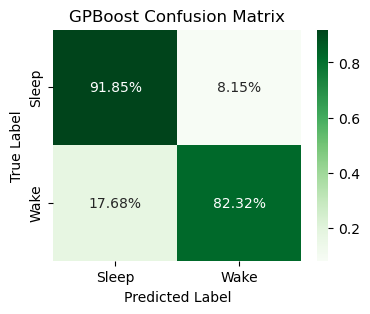

[[9096 1306]
 [1081 5466]]


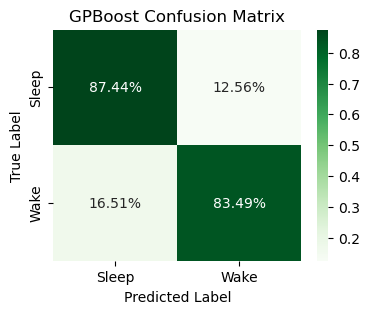

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,GPBoost,0.807147,0.834886,0.820782,0.874447,0.928169,0.907894,0.859166,0.698573


In [13]:
# calculate training scores
prob_ls_train, len_train, true_ls_train = compute_probabilities(
    train_sids, SW_df, final_features, 'gpb', final_gpb_model, group_variable)
gpb_train_results_df = GPBoost_result(final_gpb_model, X_train, y_train, group_train, prob_ls_train, true_ls_train)

# calculate testing scores
prob_ls_test, len_test, true_ls_test = compute_probabilities(
    test_sids, SW_df, final_features, 'gpb', final_gpb_model, group_variable)
gpb_test_results_df = GPBoost_result(final_gpb_model, X_test, y_test, group_test, prob_ls_test, true_ls_test)
gpb_test_results_df

### GPBoost + LSTM post processing

In [14]:
dataloader_train = LSTM_dataloader(
    prob_ls_train, len_train, true_ls_train, batch_size=32
)

# Run LSTM model
LSTM_model = LSTM_engine(dataloader_train, num_epoch=300, hidden_layer_size=32, learning_rate = 0.001) # set your num_epoch

Training on cuda:0


dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1


Epoch 5/300 - Loss: 0.6549, Accuracy: 0.6254
Epoch 10/300 - Loss: 0.6192, Accuracy: 0.6254
Epoch 15/300 - Loss: 0.5561, Accuracy: 0.8103
Epoch 20/300 - Loss: 0.4094, Accuracy: 0.8947
Epoch 25/300 - Loss: 0.3413, Accuracy: 0.8960
Epoch 30/300 - Loss: 0.3329, Accuracy: 0.8995
Epoch 35/300 - Loss: 0.3107, Accuracy: 0.9070
Epoch 40/300 - Loss: 0.3040, Accuracy: 0.9063
Epoch 45/300 - Loss: 0.3002, Accuracy: 0.9074
Epoch 50/300 - Loss: 0.2969, Accuracy: 0.9076
Epoch 55/300 - Loss: 0.2941, Accuracy: 0.9077
Epoch 60/300 - Loss: 0.2917, Accuracy: 0.9079
Epoch 65/300 - Loss: 0.2895, Accuracy: 0.9080
Epoch 70/300 - Loss: 0.2876, Accuracy: 0.9081
Epoch 75/300 - Loss: 0.2858, Accuracy: 0.9082
Epoch 80/300 - Loss: 0.2841, Accuracy: 0.9082
Epoch 85/300 - Loss: 0.2824, Accuracy: 0.9085
Epoch 90/300 - Loss: 0.2807, Accuracy: 0.9089
Epoch 95/300 - Loss: 0.2789, Accuracy: 0.9096
Epoch 100/300 - Loss: 0.2769, Accuracy: 0.9095
Epoch 105/300 - Loss: 0.2746, Accuracy: 0.9096
Epoch 110/300 - Loss: 0.2730, Acc

[[9320 1082]
 [ 824 5723]]


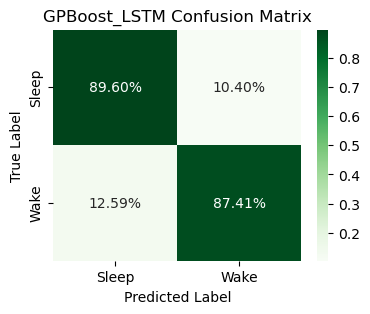

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,GPBoost_LSTM,0.840999,0.874141,0.85725,0.895982,0.942558,0.915506,0.887545,0.761084


In [15]:
dataloader_test = LSTM_dataloader(
    prob_ls_test, len_test, true_ls_test, batch_size=1
)

gpb_lstm_test_results_df = LSTM_eval(LSTM_model, dataloader_test, true_ls_test, 'GPBoost_LSTM')
gpb_lstm_test_results_df

In [16]:
overall_result = pd.concat([lgb_test_results_df, lgb_lstm_test_results_df, 
                            gpb_test_results_df, gpb_lstm_test_results_df])
print(group_variable)
overall_result

['AHI_Severity']


,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,LightGBM,0.772759,0.854437,0.811548,0.841857,0.925547,0.903694,0.846717,0.675096
0,LightGBM_LSTM,0.806598,0.866351,0.835408,0.869256,0.936992,0.914593,0.868134,0.720640
0,GPBoost,0.807147,0.834886,0.820782,0.874447,0.928169,0.907894,0.859166,0.698573
0,GPBoost_LSTM,0.840999,0.874141,0.857250,0.895982,0.942558,0.915506,0.887545,0.761084
